In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from bandits import *
from client import *
from server import *
from bandits_improved import *
from client_improved import *
from server_improved import *

Performance

In [20]:
T = int(1e6) # sum of rounds
K = 9 # number of arms
M = 4 # number of clients
alpha_list = np.array([0, 0.2, 0.5, 0.9, 1]) # alpha(hyperparameter)

# means = np.random.random((M, K))

# means = np.array([[1,   0,  0,  0,  0.9,    0.4,    0.35,   0.35,   0.5],
#                   [0,   1,  0,  0,  0.3,    0.9,    0.35,   0.3,    0.5],
#                   [0,   0,  1,  0,  0.35,   0.35,   0.9,    0.3,    0.5],
#                   [0,   0,  0,  1,  0.4,    0.3,    0.35,   0.9,    0.5]]) # 设置每个客户端上每个臂的收入期望

means = np.array([
    [0.8341121, 0.84796552, 0.83609353, 0.73813021, 0.3198767, 0.19674206, 0.30754302, 0.18119033, 0.95856425],
    [0.55631841, 0.40695561, 0.06795077, 0.4857959, 0.15341501, 0.46908026, 0.57337004, 0.07860025, 0.79762761],
    [0.39438155, 0.7437935, 0.77223112, 0.85358851, 0.26020236, 0.9881694, 0.70606617, 0.26264427, 0.79714708],
    [0.88549178, 0.19549672, 0.60599266, 0.48082989, 0.42927029, 0.81570219, 0.22458051, 0.15619685, 0.24938506]
])

n_simu = 5 # number of simulations for each alpha

print(means)

[[0.8341121  0.84796552 0.83609353 0.73813021 0.3198767  0.19674206
  0.30754302 0.18119033 0.95856425]
 [0.55631841 0.40695561 0.06795077 0.4857959  0.15341501 0.46908026
  0.57337004 0.07860025 0.79762761]
 [0.39438155 0.7437935  0.77223112 0.85358851 0.26020236 0.9881694
  0.70606617 0.26264427 0.79714708]
 [0.88549178 0.19549672 0.60599266 0.48082989 0.42927029 0.81570219
  0.22458051 0.15619685 0.24938506]]


In [21]:
def fp(p):
    return 2**p*np.log(T)

In [22]:
# try to load for a warm restart
try:
    regret_reward = np.load('scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}

try:
    raw_regret = np.load('scores/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}

try:
    local_reward = np.load('scores/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}

try:
    global_reward = np.load('scores/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}

try:
    mixed_reward = np.load('scores/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [23]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
            if nalgo <= 0:
                print(f'Using existing data for alpha: {alpha}')
                continue
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)

            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]

            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward


except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:1.0: 100%|██████████| 5/5 [06:32<00:00, 78.55s/it]


c:\Develop\Anaconda\anaconda3\envs\MAB\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


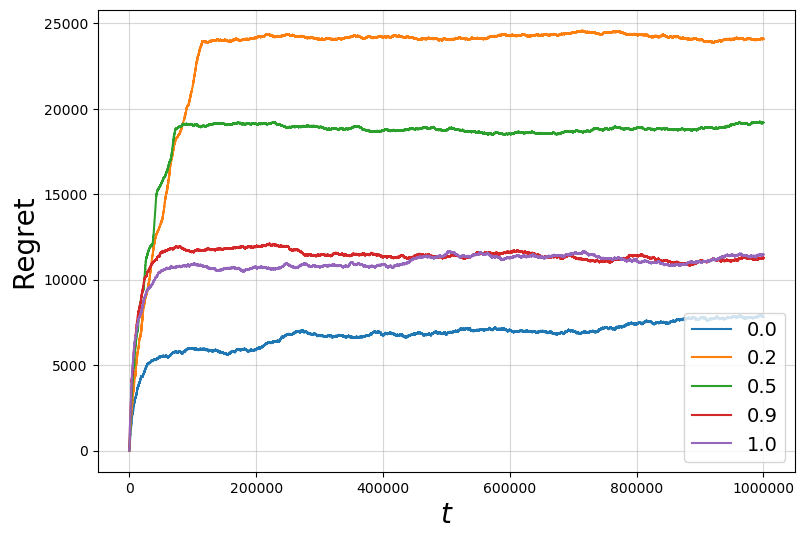

In [24]:
try:
    regret_reward = np.load('scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}

horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

Enhancement

In [25]:
T = int(1e6) # 1e4 is not sufficient

K = 9
M = 4
alpha_list = np.array([0.5])
means = np.load("means.npy")
n_simu = 5

In [26]:
# try to load for a warm restart
try:
    regret_reward = np.load('scores_improved/imp_regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}

try:
    raw_regret = np.load('scores_improved/imp_raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}

try:
    local_reward = np.load('scores_improved/imp_local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}

try:
    global_reward = np.load('scores_improved/imp_global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}

try:
    mixed_reward = np.load('scores_improved/imp_mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [27]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("Imp P-Fed-UCB, alpha:"+str(alpha))):
            pfed = IMP_PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)

            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]

            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('scores_improved/imp_raw_regret.npy', raw_regret)
    np.save('scores_improved/imp_local_reward.npy',local_reward)
    np.save('scores_improved/imp_global_reward.npy',global_reward)
    np.save('scores_improved/imp_mixed_reward.npy',mixed_reward)
    np.save('scores_improved/imp_regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward


except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(alpha)]))
    np.save('scores_improved/imp_raw_regret.npy', raw_regret)
    np.save('scores_improved/imp_local_reward.npy',local_reward)
    np.save('scores_improved/imp_global_reward.npy',global_reward)
    np.save('scores_improved/imp_mixed_reward.npy',mixed_reward)
    np.save('scores_improved/imp_regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating Imp P-Fed-UCB, alpha:0.5: 100%|██████████| 5/5 [05:24<00:00, 64.82s/it]


In [28]:
# try to load for a warm restart
try:
    regret_reward = np.load('scores_improved/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}

try:
    raw_regret = np.load('scores_improved/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}

try:
    local_reward = np.load('scores_improved/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}

try:
    global_reward = np.load('scores_improved/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}

try:
    mixed_reward = np.load('scores_improved/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [29]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)

            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]

            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('scores_improved/raw_regret.npy', raw_regret)
    np.save('scores_improved/local_reward.npy',local_reward)
    np.save('scores_improved/global_reward.npy',global_reward)
    np.save('scores_improved/mixed_reward.npy',mixed_reward)
    np.save('scores_improved/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward


except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(alpha)]))
    np.save('scores_improved/raw_regret.npy', raw_regret)
    np.save('scores_improved/local_reward.npy',local_reward)
    np.save('scores_improved/global_reward.npy',global_reward)
    np.save('scores_improved/mixed_reward.npy',mixed_reward)
    np.save('scores_improved/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:0.5: 100%|██████████| 5/5 [05:21<00:00, 64.22s/it]


c:\Develop\Anaconda\anaconda3\envs\MAB\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


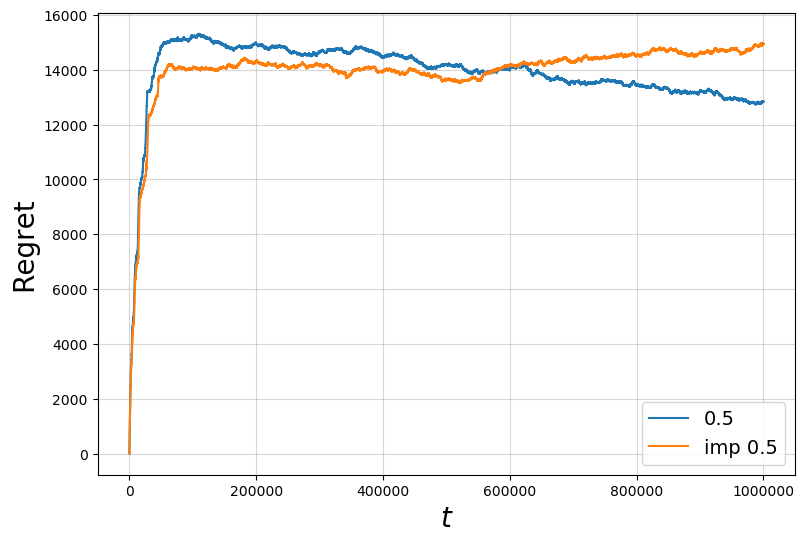

In [30]:
try:
    regret_reward = np.load('scores_improved/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}

horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))

try:
    regret_reward = np.load('scores_improved/imp_regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}

for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label='imp '+str(alpha))

plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

In [31]:
T = int(1e6) # 1e5 is not sufficient

#alpha_list = np.linspace(0, 1, num=6)
alpha_list = np.array([0, 0.1,0.9, 1])
#means = np.random.random((M, K))


means = np.load("movielens_norm_10_40.npy")
M = means.shape[0]
K = means.shape[1]

n_simu = 5

In [32]:
# try to load for a warm restart
try:
    regret_reward = np.load('scores_movielens/raw_regret_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}

try:
    raw_regret = np.load('scores_movielens/raw_regret_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}

try:
    local_reward = np.load('scores_movielens/local_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}

try:
    global_reward = np.load('scores_movielens/global_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}

try:
    mixed_reward = np.load('scores_movielens/mixed_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [33]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)

            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]

            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('scores_movielens/raw_regret_10_40.npy', raw_regret)
    np.save('scores_movielens/local_reward_10_40.npy',local_reward)
    np.save('scores_movielens/global_reward_10_40.npy',global_reward)
    np.save('scores_movielens/mixed_reward_10_40.npy',mixed_reward)
    np.save('scores_movielens/regret_reward_10_40.npy', regret_reward)
    del raw_regret, local_reward, global_reward, mixed_reward, regret_reward


except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores_movielens/raw_regret_10_40.npy', raw_regret)
    np.save('scores_movielens/local_reward_10_40.npy',local_reward)
    np.save('scores_movielens/global_reward_10_40.npy',global_reward)
    np.save('scores_movielens/mixed_reward_10_40.npy',mixed_reward)
    np.save('scores_movielens/regret_reward_10_40.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:1.0: 100%|██████████| 5/5 [09:47<00:00, 117.44s/it]


c:\Develop\Anaconda\anaconda3\envs\MAB\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


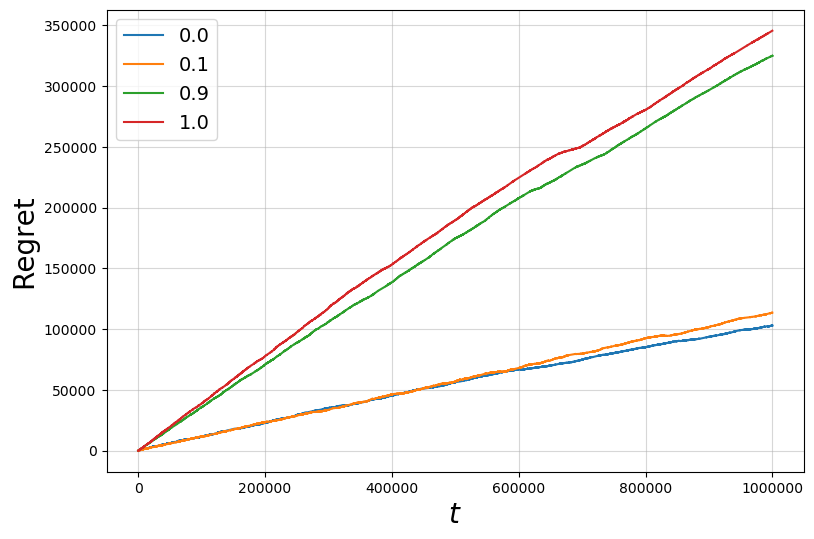

In [34]:
try:
    regret_reward = np.load('scores_movielens/regret_reward_10_40.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}

horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)